<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monta o google drive

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dados dos hoteis

In [5]:
date = "2023/06/21"

## Cria o DataFrame

### conferindo a versão do sns

In [6]:
sns.__version__

'0.12.2'

### carregando um unico arquivo

In [ ]:
filename = 'aram-beach-&-convention-gm-reviews.csv'
df = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
df['source'] = filename.split('.')[0]
df.loc[1]['text']

'Fui com meu filho nas minhas férias e não recomendo para ninguém, além dos quartos com uma acústica ruim, eles cobram caro o estacionamento que no site de reserva não fala, outro ponto que na hora do checkout o recepcionista queria cobrar uma taxa extra de serviço e quando falei que não iria pagar ele fechou a cara e me atendeu super mau.'

### carregando todos os arquivos da pasta

In [7]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)
print(len(set(files)))
df = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)
## VERIFICAR: sumiram/faltam dois arquivos?
len(set(df['source']))

18


18

### Tratando dataset

#### filtrando por avaliações com mais de 2 caracteres

In [8]:
initial_count = df.shape[0]
df = df[df['text'].notna()]
df = df[df['text'].str.len() > 2] ## deveria filtrar por tamanho minimo de texto?
filtered_count = df.shape[0]
filtered_count

91742

#### quantidade total de reviews

In [9]:
initial_count ## reviews no total com e sem texto

128929

#### quantidade de reviews com 2 ou menos caracteres

In [10]:
initial_count - filtered_count ## reviews sem texto

37187

#### quantidade de reviews com mais de 2 caracteres

In [11]:
filtered_count ## reviews com texto

91742

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

##### definindo transformações

In [12]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um':
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

# Função para detectar idioma, tratando valores nulos e textos vazios
def detectar_idioma(texto):
    if texto and len(texto) > 2:  # Verificar se o texto não é nulo e não está vazio
        try:
          lang = detect(texto)
          return lang
        except:
          print(f"deu ruim {texto}")

    return None

def obtem_data(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date

  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

  return (dt_timestamp - data_relativa).date()

##### transformações rápidas

In [13]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0)

df['data_avaliacao'] = pd.to_datetime(df.apply(obtem_data, axis=1))

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')

df['ano_avaliacao'].value_counts()

2022    29734
2023    17474
2019    11851
2021    10395
2020     9722
2018     8411
2017     3057
2016      721
2015      203
2014       96
2013       68
2012        8
2011        2
Name: ano_avaliacao, dtype: int64

#### exemplo

In [14]:
df.head()

,token,review_id,retrieval_date,rating,rating_max,relative_date,likes,other_ratings,trip_type_travel_group,user_name,...,user_url,text,response_text,response_relative_date,errors,source,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao
0,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNKc0xPRk9nEAE,2023-06-21 19:53:17.211961,5.0,5.0,2 dias atrás,1,"Destaques do hotel Luxuoso, Vista linda, Ambie...",Férias | Casal,Sakura,...,https://www.google.com/maps/contrib/1182773364...,"O Hotel é simplesmente incrível, atendentes su...",NaN,NaN,[],hotel-marsol-beach-resort,2023-06-19,6,2023,2023-06
1,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNKNElLWktnEAE,2023-06-21 19:53:17.261651,5.0,5.0,2 dias atrás,0,Quartos : 4/5 | Serviço : 5/5 | Local : 3/5,NaN,Adriana Jait,...,https://www.google.com/maps/contrib/1003253972...,(Tradução do Google) Muito poucos doces e sobr...,NaN,NaN,[],hotel-marsol-beach-resort,2023-06-19,6,2023,2023-06
2,CAESBkVnSUlDZw==,ChdDSUhNMG9nS0VJQ0FnSUNKNE5MQTRBRRAB,2023-06-21 19:53:17.280373,5.0,5.0,2 dias atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5,NaN,Carol Pires,...,https://www.google.com/maps/contrib/1081568914...,Ótima localização. Amei o serviço! Voltarei co...,NaN,NaN,[],hotel-marsol-beach-resort,2023-06-19,6,2023,2023-06
3,CAESBkVnSUlDZw==,ChdDSUhNMG9nS0VJQ0FnSUR4MzhyQWdBRRAB,2023-06-21 19:53:17.311936,5.0,5.0,3 dias atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5,NaN,Fisioterapia Especializada RJ,...,https://www.google.com/maps/contrib/1145544512...,"Aconchegante, bem localizado e com ótimo servi...",NaN,NaN,[],hotel-marsol-beach-resort,2023-06-18,6,2023,2023-06
4,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUR4MTdxVE1BEAE,2023-06-21 19:53:17.341585,5.0,5.0,5 dias atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5,NaN,Lucas Fernando,...,https://www.google.com/maps/contrib/1075995592...,É um ótimo hotel para levar a família e curtir...,NaN,NaN,[],hotel-marsol-beach-resort,2023-06-16,6,2023,2023-06


### analise exploratoria

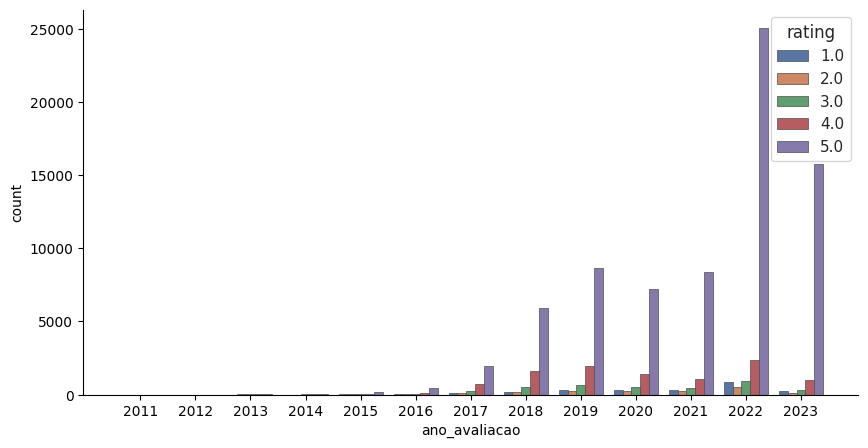

In [15]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="ticks")
sns.despine(f)

sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=df,
    edgecolor=".3",
    linewidth=.5,
)
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

<Axes: xlabel='rating', ylabel='count'>

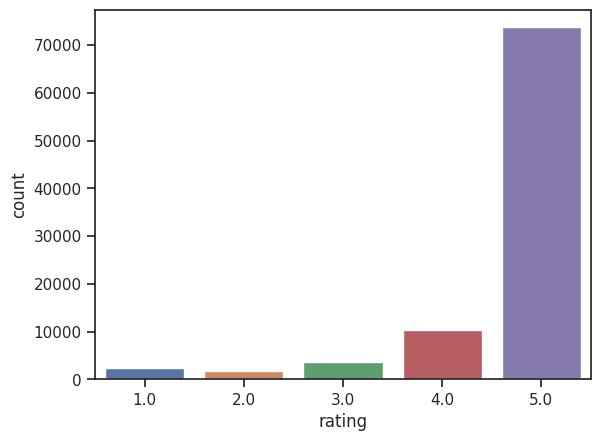

In [16]:
sns.countplot(x="rating", data=df)

In [17]:
df[['source', 'rating']].groupby(['source']).size().reset_index(name='counts').sort_values("counts", ascending=False)

,source,counts
2,grand-palladium-imbassaí-resort-&-spa,16354
8,iberostar-bahia,10506
16,sauípe-premium-brisa---all-inclusive,8510
0,cana-brava-all-inclusive-resort,8432
9,iberostar-selection-praia-do-forte,6478
6,hotel-vila-galé-marés,5655
5,hotel-vila-galé---touros,4318
15,salinas-maragogi-all-inclusive-resort,4260
10,la-torre-resort-all-inclusive,3779
7,hotel-vila-galé:-eco-resort---cabo,3203


In [18]:
df.describe()

,rating,rating_max,likes,user_photos,mes_avaliacao,ano_avaliacao
count,91742.000000,91742.0,91742.000000,44229.000000,91742.000000,91742.000000
mean,4.651348,5.0,0.149048,59.362529,6.000883,2020.865558
std,0.848339,0.0,0.674147,131.856949,1.760390,1.852833
min,1.000000,5.0,0.000000,1.000000,1.000000,2011.000000
25%,5.000000,5.0,0.000000,2.000000,6.000000,2019.000000
50%,5.000000,5.0,0.000000,10.000000,6.000000,2022.000000
75%,5.000000,5.0,0.000000,46.000000,6.000000,2022.000000
max,5.000000,5.0,32.000000,999.000000,12.000000,2023.000000


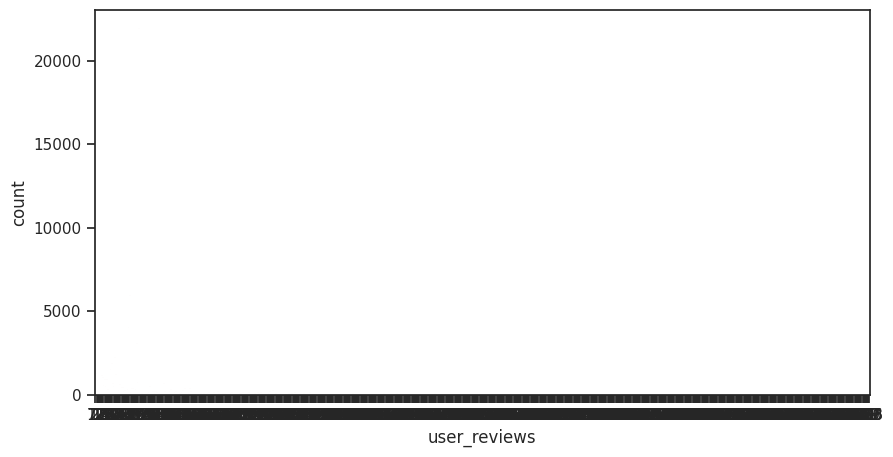

In [19]:
## quantidade de reviews por usuario

## diminuir a quantidade de valores analisados TODO
## grafico de cima est'a estragando a escala aqui TODO
plt.figure(figsize=(10,5))
sns.countplot(x='user_reviews', data=df)
plt.show()

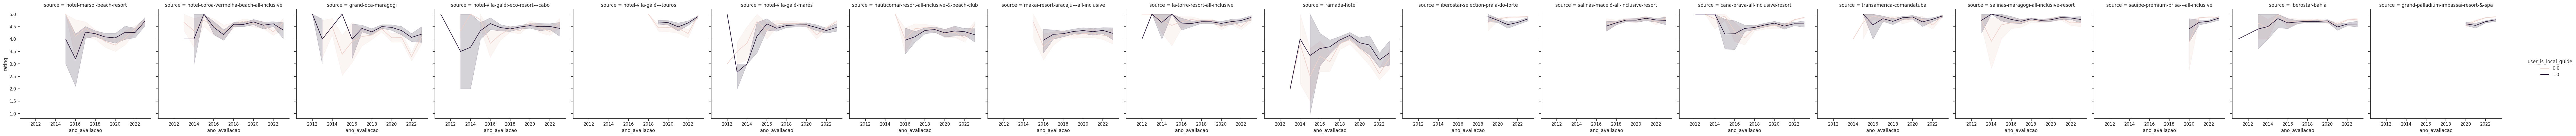

In [20]:
## n~ao funciona legal com muitos sources

sns.relplot(
    x='ano_avaliacao',
    y='rating',
    col='source',
    hue='user_is_local_guide',
    kind="line",
    data=df
)

In [21]:
df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews
0,5.0,"O Hotel é simplesmente incrível, atendentes su...",2023-06-19,False,11
1,5.0,(Tradução do Google) Muito poucos doces e sobr...,2023-06-19,True,72
2,5.0,Ótima localização. Amei o serviço! Voltarei co...,2023-06-19,False,17
3,5.0,"Aconchegante, bem localizado e com ótimo servi...",2023-06-18,False,11
4,5.0,É um ótimo hotel para levar a família e curtir...,2023-06-16,False,2


<Figure size 1000x500 with 0 Axes>

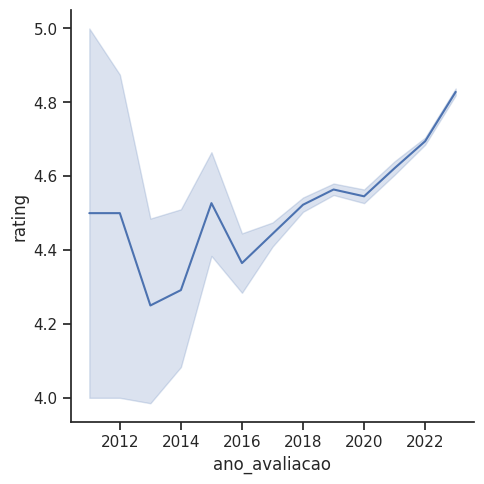

In [22]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=df)

In [23]:
## 20646 como tratar essa galera? 66 hoteis / freq 4116 grand-palladium-imbassaí-resort-&-spa sem considerar a identificação do idioma

df[df['text'].str.contains('Tradução do Google')].describe()

,rating,rating_max,likes,user_photos,mes_avaliacao,ano_avaliacao
count,9114.000000,9114.0,9114.000000,4780.000000,9114.000000,9114.000000
mean,4.680711,5.0,0.106101,75.065259,5.683673,2020.733706
std,0.764262,0.0,0.392568,148.551218,2.294346,2.046178
min,1.000000,5.0,0.000000,1.000000,1.000000,2011.000000
25%,5.000000,5.0,0.000000,3.000000,5.000000,2019.000000
50%,5.000000,5.0,0.000000,15.000000,6.000000,2022.000000
75%,5.000000,5.0,0.000000,68.000000,6.000000,2023.000000
max,5.000000,5.0,7.000000,999.000000,12.000000,2023.000000


In [24]:
trad = df[df['text'].str.contains('Tradução do Google')]
trad.describe()

,rating,rating_max,likes,user_photos,mes_avaliacao,ano_avaliacao
count,9114.000000,9114.0,9114.000000,4780.000000,9114.000000,9114.000000
mean,4.680711,5.0,0.106101,75.065259,5.683673,2020.733706
std,0.764262,0.0,0.392568,148.551218,2.294346,2.046178
min,1.000000,5.0,0.000000,1.000000,1.000000,2011.000000
25%,5.000000,5.0,0.000000,3.000000,5.000000,2019.000000
50%,5.000000,5.0,0.000000,15.000000,6.000000,2022.000000
75%,5.000000,5.0,0.000000,68.000000,6.000000,2023.000000
max,5.000000,5.0,7.000000,999.000000,12.000000,2023.000000


In [25]:
## deveriam ser removidos?
trad[['text']]

,text
1,(Tradução do Google) Muito poucos doces e sobr...
34,Place good (Tradução do Google) Coloque bem Qu...
50,Hotel top (Tradução do Google) topo do hotel Q...
103,A Good place to rest in South America. (Traduç...
139,(Tradução do Google) lindooo (Original) Lindoo...
...,...
128912,"(Tradução do Google) O lugar é excelente, tudo..."
128918,(Tradução do Google) É precioso (Original) Es ...
128921,"(Tradução do Google) Hotel, do pé boca mão vír..."
128923,(Tradução do Google) Um dos melhores hotéis qu...


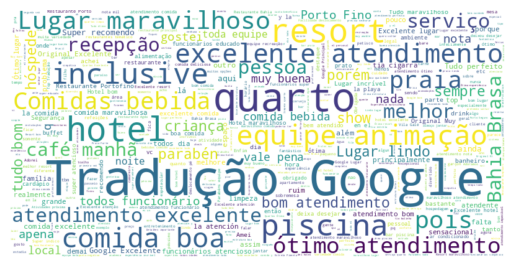

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

# Concatenar todos os textos em uma única string
texto = ' '.join(df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

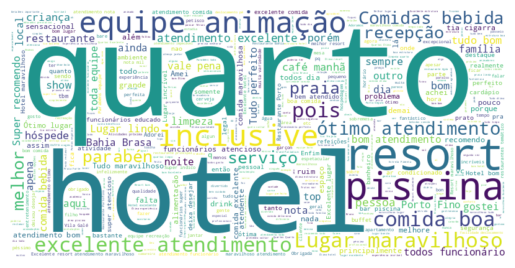

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
filtro = ~df['text'].str.contains('Tradução do Google')
text = df[filtro]

# Concatenar todos os textos em uma única string
texto = ' '.join(text['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

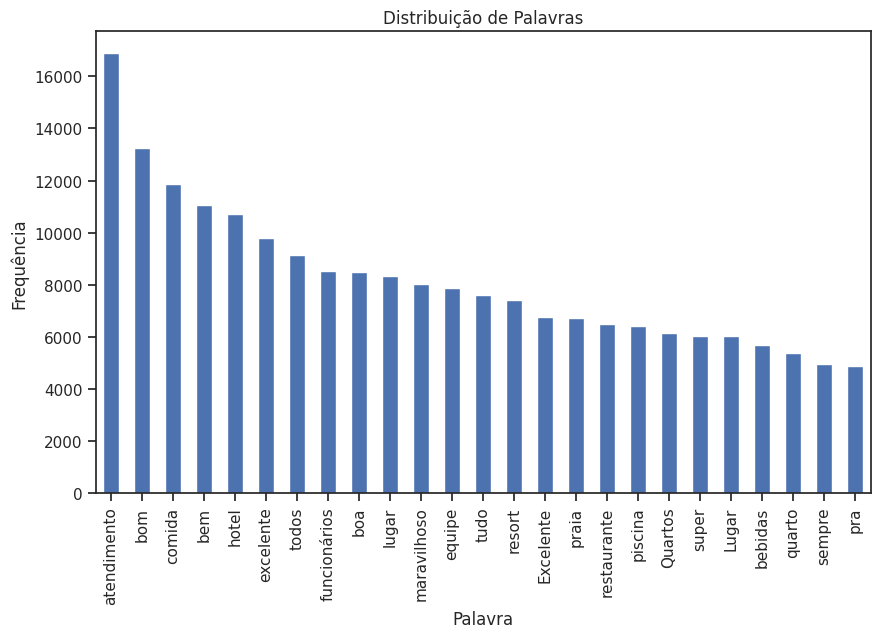

In [45]:
# Dividir a string em palavras
palavras = texto_sem_stopwords.split()

# Contar as ocorrências de cada palavra
contagem = pd.Series(palavras).value_counts().head(25)

# Criar um gráfico de barras para visualizar a distribuição de palavras
contagem.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()

In [33]:
from nltk.probability import FreqDist
#Create your bigrams
bgs = nltk.bigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(bgs)

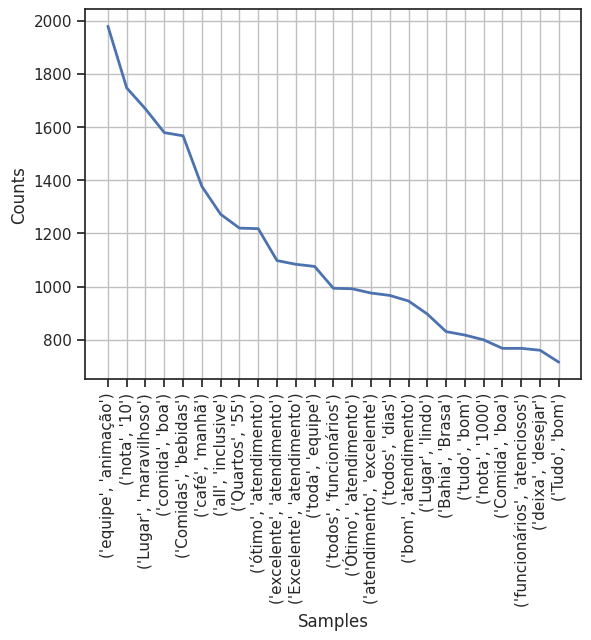

<Axes: xlabel='Samples', ylabel='Counts'>

In [51]:
fdist.plot(25)

# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [ ]:
!nvidia-smi

Fri Jun  9 20:43:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |   1607MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.2 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, TFBertForSequenceClassification

In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def to_sentiment(rating):
  rating = float(rating)
  if rating < 3:
    return 0
  elif rating > 4:
    return 2
  else:
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)
df.head()

,token,review_id,retrieval_date,rating,rating_max,relative_date,likes,other_ratings,trip_type_travel_group,user_name,...,text,response_text,response_relative_date,errors,source,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,sentiment
1,CAESBkVnSUlDZw==,ChdDSUhNMG9nS0VJQ0FnSUNod2FMV2t3RRAB,2023-02-15 02:48:02.476867,1.0,5.0,10 horas atrás,0,NaN,NaN,iranilson barbosa,...,Fui com meu filho nas minhas férias e não reco...,NaN,NaN,[],aram-beach-&-convention-gm-reviews,2023-02-14,2,2023,2023-02,0
3,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNoanBLT1ZBEAE,2023-02-15 02:48:02.487116,5.0,5.0,2 dias atrás,0,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5 De...,Férias | Casal,ricardo pereira,...,Excelente o atendimento foi maravilhoso todos ...,NaN,NaN,[],aram-beach-&-convention-gm-reviews,2023-02-13,2,2023,2023-02,2
4,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUNob3YzY1JREAE,2023-02-15 02:48:02.494936,4.0,5.0,6 dias atrás,0,NaN,NaN,geraldo goncalves,...,"Acabei de chegar,por enquanto não posso falar ...",NaN,NaN,[],aram-beach-&-convention-gm-reviews,2023-02-09,2,2023,2023-02,1
5,CAESBkVnSUlDZw==,ChdDSUhNMG9nS0VJQ0FnSUNob3ZHdHB3RRAB,2023-02-15 02:48:02.500336,4.0,5.0,6 dias atrás,0,Quartos : 4/5 | Serviço : 4/5 | Local : 4/5 De...,Férias | Casal,Paulo Lampert,...,Viagem de casal com um pernoite no sábado. Hot...,NaN,NaN,[],aram-beach-&-convention-gm-reviews,2023-02-09,2,2023,2023-02,1
6,CAESBkVnSUlDZw==,ChZDSUhNMG9nS0VJQ0FnSUQtaXJLdlZBEAE,2023-02-15 02:48:02.505463,5.0,5.0,uma semana atrás,4,Quartos : 5/5 | Serviço : 5/5 | Local : 5/5 De...,Férias | Família,Rafael Abreu - Artes Visuais,...,Quero poder deixar aqui as minhas impressões s...,NaN,NaN,[],aram-beach-&-convention-gm-reviews,2023-02-08,2,2023,2023-02,2


In [ ]:
class_names = ['negative', 'neutral', 'positive']

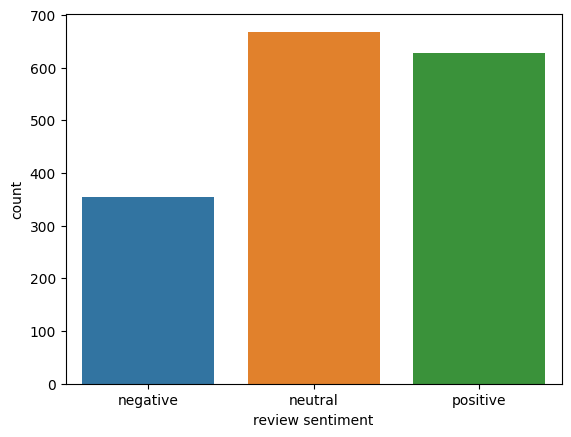

In [ ]:
ax= sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
%mkdir -p gdrive/MyDrive/tcc/bert
file_csv_data = 'gdrive/MyDrive/tcc/bert/reviews.csv'
df.to_csv(file_csv_data, index=None, header=True)

In [ ]:
sample_txt = df.loc[1]['text']
sample_txt

'Fui com meu filho nas minhas férias e não recomendo para ninguém, além dos quartos com uma acústica ruim, eles cobram caro o estacionamento que no site de reserva não fala, outro ponto que na hora do checkout o recepcionista queria cobrar uma taxa extra de serviço e quando falei que não iria pagar ele fechou a cara e me atendeu super mau.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Fui com meu filho nas minhas férias e não recomendo para ninguém, além dos quartos com uma acústica ruim, eles cobram caro o estacionamento que no site de reserva não fala, outro ponto que na hora do checkout o recepcionista queria cobrar uma taxa extra de serviço e quando falei que não iria pagar ele fechou a cara e me atendeu super mau.
   Tokens: ['Fu', '##i', 'com', 'meu', 'filho', 'nas', 'minha', '##s', 'férias', 'e', 'não', 'recomend', '##o', 'para', 'ninguém', ',', 'além', 'dos', 'quartos', 'com', 'uma', 'acústica', 'ruim', ',', 'eles', 'cobra', '##m', 'caro', 'o', 'estacionamento', 'que', 'no', 'site', 'de', 'reserva', 'não', 'fala', ',', 'outro', 'ponto', 'que', 'na', 'hora', 'do', 'che', '##ck', '##out', 'o', 'recep', '##cionista', 'queria', 'cobra', '##r', 'uma', 'taxa', 'extra', 'de', 'serviço', 'e', 'quando', 'fale', '##i', 'que', 'não', 'iria', 'pagar', 'ele', 'fechou', 'a', 'cara', 'e', 'me', 'atende', '##u', 'super', 'mau', '.']
Token IDs: [2054, 22283, 170, 

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=45,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

45


tensor([  101,  2054, 22283,   170,  7343,  1417,   529,  7122, 22281, 12949,
          122,   346,  9099, 22280,   221,  7749,   117,  1166,   298, 15050,
          170,   230, 20713, 16173,   117,  1061, 15210, 22287, 15045,   146,
        17888,   179,   202,  3834,   125,  6105,   346,  3887,   117,  1342,
         2009,   179,   229,  5314,   102])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'Fu', '##i', 'com', 'meu', 'filho', 'nas', 'minha', '##s', 'férias', 'e', 'não', 'recomend', '##o', 'para', 'ninguém', ',', 'além', 'dos', 'quartos', 'com', 'uma', 'acústica', 'ruim', ',', 'eles', 'cobra', '##m', 'caro', 'o', 'estacionamento', 'que', 'no', 'site', 'de', 'reserva', 'não', 'fala', ',', 'outro', 'ponto', 'que', 'na', 'hora', '[SEP]']


In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

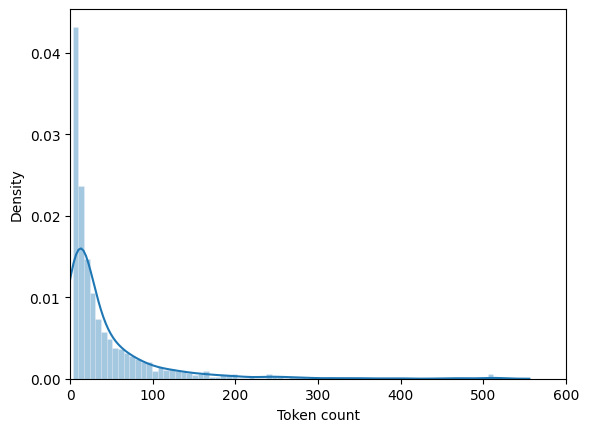

In [ ]:
# deprecated sns.distplot(token_lens)
sns.histplot(token_lens,
             kde=True,
             stat="density",
             kde_kws=dict(cut=3),
             alpha=.4,
             edgecolor=(1, 1, 1, .4),
             )
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

512

In [ ]:
MAX_LEN = 512

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((1485, 24), (83, 24), (83, 24))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(train_data_loader)

93

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.8013855757251862 accuracy 0.6127946127946128
Val   loss 0.558693011601766 accuracy 0.7951807228915663

Epoch 2/10
----------
Train loss 0.6014812945999125 accuracy 0.7447811447811448
Val   loss 0.5036831249793371 accuracy 0.7228915662650602

Epoch 3/10
----------
Train loss 0.3902578669530089 accuracy 0.8531986531986533
Val   loss 0.49490582942962646 accuracy 0.7710843373493976

Epoch 4/10
----------
Train loss 0.2691258607452275 accuracy 0.9057239057239058
Val   loss 0.7948475082715353 accuracy 0.710843373493976

Epoch 5/10
----------
Train loss 0.2027483787187325 accuracy 0.9292929292929294
Val   loss 0.8721044361591339 accuracy 0.710843373493976

Epoch 6/10
----------
Train loss 0.14424740317307652 accuracy 0.9461279461279462
Val   loss 0.9127395351727804 accuracy 0.710843373493976

Epoch 7/10
----------
Train loss 0.12101262353701137 accuracy 0.9582491582491584
Val   loss 0.9982276012500128 accuracy 0.6867469879518072

Epoch 8/10
----------
Train 

In [ ]:
history

defaultdict(list,
            {'train_acc': [tensor(0.6128, device='cuda:0', dtype=torch.float64),
              tensor(0.7448, device='cuda:0', dtype=torch.float64),
              tensor(0.8532, device='cuda:0', dtype=torch.float64),
              tensor(0.9057, device='cuda:0', dtype=torch.float64),
              tensor(0.9293, device='cuda:0', dtype=torch.float64),
              tensor(0.9461, device='cuda:0', dtype=torch.float64),
              tensor(0.9582, device='cuda:0', dtype=torch.float64),
              tensor(0.9636, device='cuda:0', dtype=torch.float64),
              tensor(0.9697, device='cuda:0', dtype=torch.float64),
              tensor(0.9697, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.8013855757251862,
              0.6014812945999125,
              0.3902578669530089,
              0.2691258607452275,
              0.2027483787187325,
              0.14424740317307652,
              0.12101262353701137,
              0.09985830979571948,

In [ ]:
history['train_acc']

tensor(0.6128, device='cuda:0', dtype=torch.float64)

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

AttributeError: ignored

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

NameError: ignored

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)